<h3>Load required libraries</h3>

In [1]:
import configparser #install as  ConfigParser
import pandas as pd
import pandas_profiling as ppf
import numpy as np
import dropbox
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<h3>Pull flat file data from dropbox</h3>

In [2]:
config = configparser.ConfigParser()
config.read("C:/Users/Rohan/Desktop/Columbia/IEOR 4523 - Data Analytics/Project/desal_configuration.txt")
auth_token = config.get("configuration","auth_token")

In [182]:
#input file names and path to navigate through dropbox
solar_name = 'solar_desaldata v4.0.csv'
dbx_path = '/Group Project - Solar Desal/Datasets/1 - GWI'

In [197]:
dbx = dropbox.Dropbox(auth_token)
md, res = dbx.files_download(dbx_path+'/'+solar_name)

In [198]:
df = pd.read_csv(pd.compat.BytesIO(res.content),encoding = "ISO-8859-1")

C:\Users\Rohan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (23,24,38,48,50,52,61,63,65,67,80,85,87,89,93,95,96,98,100,106,111,116,127,128,129,130,133,134,135,138,139,140,143,144,145,153,159,160,174) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [199]:
water_name = 'water_stress.xlsx'
water_path = '/Group Project - Solar Desal/Datasets/2 - Water Stress WRI'
md, res = dbx.files_download(water_path+'/'+water_name)
xls = pd.ExcelFile(pd.compat.BytesIO(res.content))
df_water = pd.read_excel(xls, 'Baseline Water Stress')

In [200]:
df = df.set_index('Country').join(df_water.set_index('Country')).reset_index()

In [202]:
ngp_name = 'NGP.xls'
ngp_path = '/Group Project - Solar Desal/Datasets/3 - Natural Gas Prices'
md, res = dbx.files_download(ngp_path+'/'+ngp_name)
xls = pd.ExcelFile(pd.compat.BytesIO(res.content))
df_ngp = pd.read_excel(xls, 'Data 1')

In [203]:
df = df.set_index('Award date').join(df_ngp.set_index('Award date')).reset_index()
#Water Stress, Inflation Adjusted Wellhead Natural Gas Price

In [259]:
df['Water Stress'] = df['Water Stress'].replace('-',np.NaN)

<h3>Review Profile Report for Missing Data</h3>
The report shows us a number of columns have missing elements. Fields with significant missing values are removed immediately. Other fields that we know are important for price estimates are kept and later imputed. 

In [6]:
pf = ppf.ProfileReport(df)

In [260]:
#After reviewing the ppf report and keeping features with at least 50% observation, then adding back features known to have high impact (such as prices), we ended with the following feature set:
# 'Award date','Capacity (m3/d)','Capacity (MGD)', 'Capital Cost per Unit of Daily Capacity ($/m3/d)','Country','Customer type','EPC contractor (desal)','EPC price','Feedwater','Holding Company',Inflation Adjusted EPC','Latitude','Location','Location','Location type','Location type','Longitude','Membrane type (RO)','Online date','Owner - Client','Plant status','Plant supplier','Plant supplier share','Plant type','Procurement model','Project name','Region','RO Feed Pump Drive','RO Membrane Type','RO System','Size','Subregion','Technology','Thermal design','Unit size (m3/d)','Units', 'Winner', 'Water price (USD/m3)'
mdf = df[['Award date','Capacity (m3/d)','Capacity (MGD)', 'Capital Cost per Unit of Daily Capacity ($/m3/d)','Country','Customer type','EPC contractor (desal)','EPC price','Feedwater','Holding Company','Inflation Adjusted EPC','Inflation Adjusted Wellhead Natural Gas Price','Latitude','Location','Location type','Longitude','Membrane type (RO)','Online date','Owner - Client','Plant status','Plant supplier','Plant supplier share','Plant type','Procurement model','Project name','Region','RO Feed Pump Drive','RO Membrane Type','RO System','Size','Subregion','Technology','Thermal design','Unit size (m3/d)','Units', 'Winner', 'Water price (USD/m3)','Water Stress']]

<h3>Data Cleaning</h3>
Here we go through a series of steps to remove missing and outlier data points. At the start of the exercise we have 18k records

In [261]:
print("Initial file size "+str(len(mdf)))

Initial file size 18741


Keep positive price records (implicitely removes 0's and nulls)

In [262]:
mdf = mdf[mdf['Inflation Adjusted EPC']>0]
print("New file size "+str(len(mdf)))

New file size 9728


Remove records exceeding the 5th and 95th bounds for outliers

In [263]:
minbound = mdf['Inflation Adjusted EPC'].quantile(q=0.05)
maxbound = mdf['Inflation Adjusted EPC'].quantile(q=0.95)
mdf = mdf[mdf['Inflation Adjusted EPC']<=maxbound]
mdf = mdf[mdf['Inflation Adjusted EPC']>=minbound]
print("New file size "+str(len(mdf)))

New file size 8748


<h3>Adjusting for Inflation</h3>
In the first plot we show EPC Price over time, which clearly has an upward sloping curve. To solve for this we adjusted the price in our offline flat file to produce Inflation Adjusted EPC (presented in the second plot). 

C:\Users\Rohan\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2800x1800 with 0 Axes>

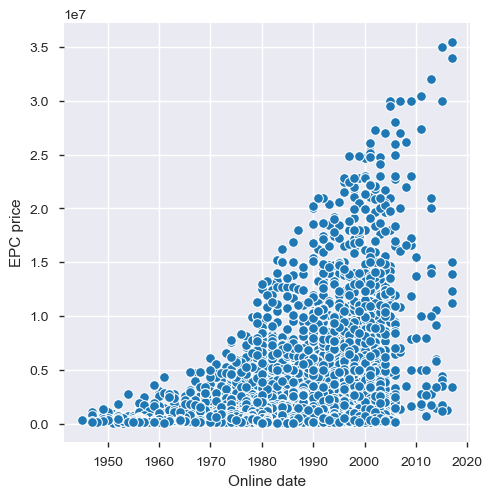

<Figure size 2800x1800 with 0 Axes>

In [12]:
ax = sns.pairplot(x_vars=["Online date"], y_vars=["EPC price"], data=mdf, size=5)
plt.figure(figsize=(28, 18))

C:\Users\Rohan\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2800x1800 with 0 Axes>

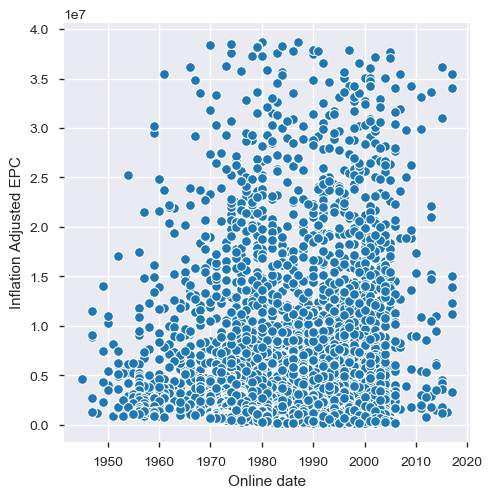

<Figure size 2800x1800 with 0 Axes>

In [13]:
sns.pairplot(x_vars=["Online date"], y_vars=["Inflation Adjusted EPC"], data=mdf, size=5)
plt.figure(figsize=(28, 18))

Since we adjusted output prices for inflation, we need to also adjust the input price of water. Before we could adjust water, we need to scrape water prices per country from a website. The getCountryPrices goes to a website for a given country id (integer) and returns a set of variables containing the Country Name, most recent year of water prices, and the price for that year. 

In [15]:
def getCountryPrices(cid):
    import requests
    from bs4 import BeautifulSoup
    url = "https://database.ib-net.org/country_profile?ctry="+str(cid)+"&years=2018,2017,2016,2015,2014,2013&type=report&ent=country&mult=true&table=true&chart=false&chartType=column&lang=en&exch=1"
    response = requests.get(url)
    soup = BeautifulSoup(response.content,'lxml')
    try:
        country_name = soup.find('li',class_='active').find('span').get_text().split('Country Profile ')[1]
    except:
        country_name = None
    #print(country_name)
    year = None
    cost = None
    if(country_name != None):
        for f in soup.find_all('script'):
            if (f.get('type') == 'text/javascript'):
                if(f.get('src') == None):
                    if('Costs, US$ per m3 sold' in f.get_text()):
                        years = list()
                        for x in f.get_text().split('xAxis')[1].split('[')[1].split(']')[0].split(','):
                            try:
                                years.append(int(x))
                            except:
                                years.append(0)
                                #print('--year error')
                        #years = [int(i) for i in (f.get_text().split('xAxis')[1].split('[')[1].split(']')[0].split(','))]
                        #print(years)
                        costs = list()
                        for x in f.get_text().split('Costs, US$ per m3 sold')[1].split('data')[1].split('[')[1].split(']')[0].split(','):
                            try:
                                costs.append(float(x))
                            except:
                                costs.append(0.0)
                                #print('--cost error')
                        #costs = [float(i) for i in f.get_text().split('Costs, US$ per m3 sold')[1].split('data')[1].split('[')[1].split(']')[0].split(',')]
                        #print(costs)
                        year = max(years)
                        cost = costs[len(costs)-1]
                        break
    return country_name, year, cost

We then pass through a large set of country id's to build a dictionary of country water prices. 

In [16]:
waterPrices = {}
#cnt = 0
for i in range(300):
    #print(cnt)
    n,y,c = getCountryPrices(i)
    waterPrices[n] = {'year':y,'cost':c}
    #cnt += 1

We leverage the mapWater function as we pass through each record in our dataframe to set the year and as-of water cost

In [17]:
def mapWater(x,feat):
    if(waterPrices.get(x) == None):
        return None
    else:
        if(feat == 'year'):
            return waterPrices.get(x)['year']
        else:
            return waterPrices.get(x)['cost']

In [264]:
mdf['Water Year'] = mdf['Country'].apply(lambda x:mapWater(x,'year'))
mdf['Water Cost'] = mdf['Country'].apply(lambda x:mapWater(x,'cost'))

Given the Water Year and Water Cost, we can perform a look-up from the original dataframe to find the corresponding inflation adjustment factor to correctly adjust the cost of water!

In [265]:
infl_dict = {}
infl_set = df[['Inflation Multiple','Online date']].drop_duplicates(inplace=False)
for x in range(len(infl_set)):
    infl_dict[infl_set.iloc[x]['Online date']] = infl_set.iloc[x]['Inflation Multiple']

In [266]:
def infl_map(year):
    if(infl_dict.get(year) == None):
        return 0.0
    else:
        return infl_dict.get(year)

In [267]:
mdf['Water Inflation Multiple'] = mdf['Water Year'].apply(lambda x:infl_map(x))

In [268]:
mdf['Inflation Adjusted Water Cost'] = mdf.apply(lambda x:x['Water Year']*x['Water Inflation Multiple'],axis=1)

The water prices available only provided water cost for 2460 records across 61 countries. We will revisit this problem shortly, and will not throw out records with missing water data. 

In [269]:
mdf['Inflation Adjusted Water Cost'].describe()

count    2460.000000
mean     1716.234312
std       899.185723
min         0.000000
25%      2017.000000
50%      2085.325764
75%      2259.470961
max      2600.426045
Name: Inflation Adjusted Water Cost, dtype: float64

In [270]:
water_countries = mdf[['Country','Inflation Adjusted EPC','Inflation Adjusted Water Cost']][mdf['Inflation Adjusted Water Cost']>0]['Country'].unique()
print(len(water_countries))
print(water_countries)

61
['India' 'Turkey' 'Argentina' 'Switzerland' 'Australia' 'Mauritania'
 'Namibia' 'Ecuador' 'Mexico' 'Iraq' 'Egypt' 'Kuwait' 'Chile'
 'South Africa' 'Azerbaijan' 'Cyprus' 'Nigeria' 'South Korea' 'Bahrain'
 'Indonesia' 'Philippines' 'French Polynesia' 'Pakistan' 'Honduras'
 'Sudan' 'Senegal' 'Singapore' 'Brazil' 'Tunisia' 'Peru'
 'Northern Mariana Islands' 'Poland' 'Malaysia' 'Portugal' 'Serbia'
 'Ukraine' 'Yemen' 'Dominican Republic' 'Nicaragua' 'China' 'Jordan'
 'Russia' 'Marshall Islands' 'Belarus' 'Czech Republic' 'Colombia'
 'Hungary' 'Norway' 'Guam' 'Kazakhstan' 'Botswana' 'Bulgaria' 'Uzbekistan'
 'Kenya' 'Paraguay' 'Fiji' 'Guinea' 'Costa Rica' 'New Zealand' 'Vietnam'
 'Mauritius']


<h3>Final Cleaning</h3>
To prepare our data for analysis we need to remove any records with missing geolocation since this is critical for our geo clustering. We also remove 1 record with a missing Capacity.

We then split out data into training (70%) and test sets

In [271]:
print("Prior file size "+str(len(mdf)))
mdf = mdf[(mdf['Latitude'].notna()) & (mdf['Longitude'].notna())]
mdf = mdf[mdf['Capacity (MGD)'].notna()]
print("New file size "+str(len(mdf)))

Prior file size 8748
New file size 6823


In [272]:
msk = np.random.rand(len(mdf)) < 0.7
train = mdf[msk]
test = mdf[~msk]

<h3>Geo Clustering</h3>
In order to impute Water Costs, and later normalize continuous variables, we cluster the training set by Latitude and Longitude using K-Means. Looking at the output elbow plot, we believe a hyperparameter of k=4 is reasonable. 

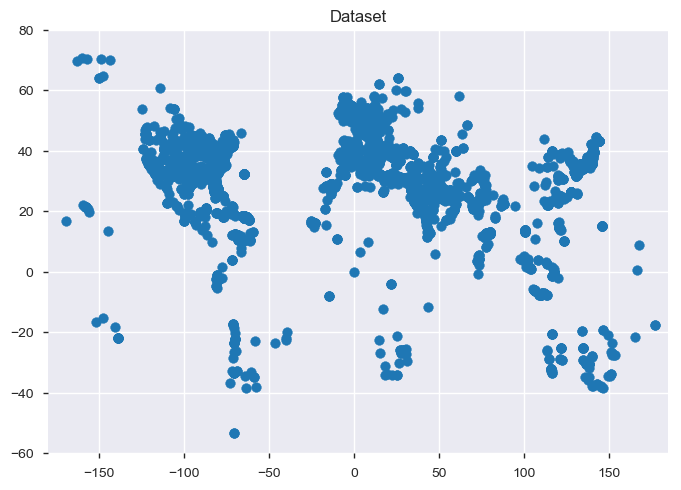

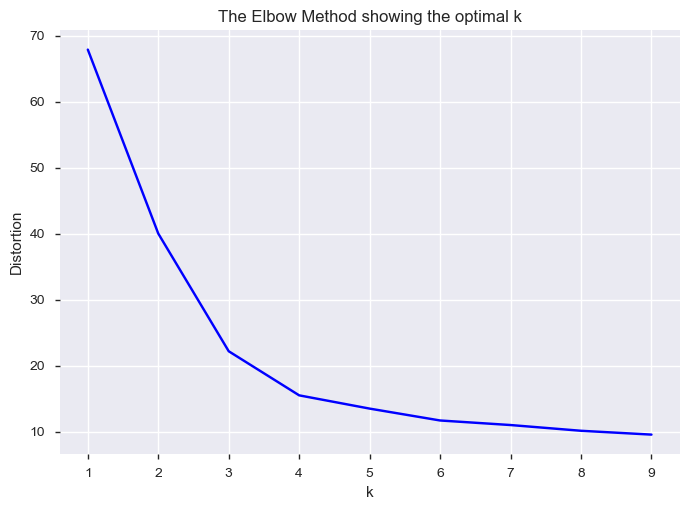

In [273]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

x2 = train['Latitude']
x1 = train['Longitude']

plt.plot()
plt.xlim([-180, 185])
plt.ylim([-60, 80])
plt.title('Dataset')
plt.scatter(x1, x2)
plt.show()

# create new plot and data
plt.plot()
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [274]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(train[['Latitude','Longitude']])

Through a cursory glance it appears the clustering makes sense given the countries that appear in each cluster. Looking at a final plot of the training clusters, we feel this is a reasonable approach. 

In [275]:
print(train.iloc[np.where(kmeans.labels_ == 0)[0]]['Country'].unique())
print(train.iloc[np.where(kmeans.labels_ == 1)[0]]['Country'].unique())
print(train.iloc[np.where(kmeans.labels_ == 2)[0]]['Country'].unique())
print(train.iloc[np.where(kmeans.labels_ == 3)[0]]['Country'].unique())

['Argentina' 'Puerto Rico' 'U.S.A.' 'Mexico' 'Canada' 'Ecuador' 'Chile'
 'Bermuda' 'U.S. Virgin Islands' 'Bonaire, Sint Eustatius and Saba'
 'French Polynesia' 'Antigua and Barbuda' 'Honduras' 'Bahamas' 'Curaçao'
 'British Virgin Islands' 'Sint Maarten' 'Peru' 'Cayman Islands'
 'Nicaragua' 'Aruba' 'Brazil' 'El Salvador' 'Venezuela' 'Colombia'
 'Saint Barthelemy' 'Trinidad and Tobago' 'Jamaica' 'Saint Martin' 'Guam'
 'Dominican Republic' 'United States Minor Outlying Islands' 'Cuba'
 'Turks and Caicos Islands' 'Paraguay' 'Belize' 'Grenada' 'Barbados'
 'Costa Rica' 'France' 'Anguilla' 'Haiti']
['U.K.' 'Germany' 'Morocco' 'Finland' 'Sweden' 'Mauritania' 'Saint Helena'
 'Spain' 'Netherlands' 'Libya' 'Algeria' 'Gibraltar' 'Italy' 'France'
 'Malta' 'Ireland' 'Greece' 'Senegal' 'Belgium' 'Cabo Verde' 'Egypt'
 'Tunisia' 'Liechtenstein' 'Poland' 'Switzerland' 'Austria' 'Portugal'
 'Serbia' 'Belarus' 'Czech Republic' 'Nigeria' 'Hungary' 'Denmark'
 'Russia' 'United Arab Emirates' 'Guinea' 'Turkey

In [276]:
train['GeoCluster'] = kmeans.labels_

C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


C:\Users\Rohan\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2800x1800 with 0 Axes>

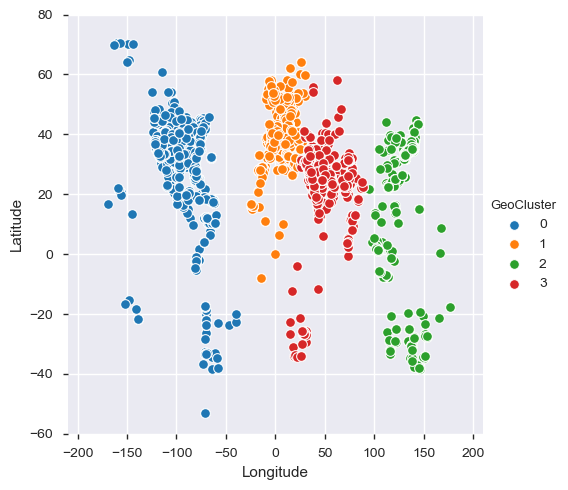

<Figure size 2800x1800 with 0 Axes>

In [277]:
sns.pairplot(x_vars=["Longitude"], y_vars=["Latitude"], data=train, hue="GeoCluster", size=5)
plt.xlim([-210, 210])
plt.ylim([-60, 80])
plt.figure(figsize=(28, 18))

With the clusters defined, we can use leverage the populated data within each field of the training set to keep track of assumed gaussian distribution parameters. This parameter dictionary is maintained only for continuous variables in the dataset. 

In [278]:
cluster_summary = {}
for k in range(4):
    cluster_data = train.iloc[np.where(kmeans.labels_ == k)[0]]
    field_summary = {}
    field_set = ['Capacity (MGD)','Units','Unit size (m3/d)','Inflation Adjusted EPC','Inflation Adjusted Water Cost','Water Stress','Inflation Adjusted Wellhead Natural Gas Price']
    for f in field_set:
        print(str(k)+f)
        field = cluster_data[f].dropna(inplace=False)
        field_summary[f] = {'mean':field.mean(), 'sdev':field.std()}
    cluster_summary[k] = field_summary

0Capacity (MGD)
0Units
0Unit size (m3/d)
0Inflation Adjusted EPC
0Inflation Adjusted Water Cost
0Water Stress
0Inflation Adjusted Wellhead Natural Gas Price
1Capacity (MGD)
1Units
1Unit size (m3/d)
1Inflation Adjusted EPC
1Inflation Adjusted Water Cost
1Water Stress
1Inflation Adjusted Wellhead Natural Gas Price
2Capacity (MGD)
2Units
2Unit size (m3/d)
2Inflation Adjusted EPC
2Inflation Adjusted Water Cost
2Water Stress
2Inflation Adjusted Wellhead Natural Gas Price
3Capacity (MGD)
3Units
3Unit size (m3/d)
3Inflation Adjusted EPC
3Inflation Adjusted Water Cost
3Water Stress
3Inflation Adjusted Wellhead Natural Gas Price


In [280]:
cluster_summary

{0: {'Capacity (MGD)': {'mean': 0.7517087062652563, 'sdev': 1.597648723207375},
  'Units': {'mean': 1.5036915504511894, 'sdev': 1.215233558211785},
  'Unit size (m3/d)': {'mean': 1548.8685479901558, 'sdev': 2737.515907917269},
  'Inflation Adjusted EPC': {'mean': 5205560.895534991,
   'sdev': 6820942.891116325},
  'Inflation Adjusted Water Cost': {'mean': 2020.133958384713,
   'sdev': 561.0847006487843},
  'Water Stress': {'mean': 2.954641203850269, 'sdev': 1.1951846161405983},
  'Inflation Adjusted Wellhead Natural Gas Price': {'mean': 3.2245156239737716,
   'sdev': 1.5877318155457927}},
 1: {'Capacity (MGD)': {'mean': 0.5112524271844658,
   'sdev': 1.0302885725041246},
  'Units': {'mean': 1.4975657254138266, 'sdev': 1.1808840950405024},
  'Unit size (m3/d)': {'mean': 1162.421606621227, 'sdev': 1838.7012126828256},
  'Inflation Adjusted EPC': {'mean': 4875282.883100094,
   'sdev': 6799142.868788754},
  'Inflation Adjusted Water Cost': {'mean': 653.6440351545987,
   'sdev': 994.5285752

<h3>Imputing Water Costs</h3>
Using the fillWater() function we can pull the average Inflation Adjusted Water Cost for the cluster! 

In [281]:
def fillWater(value,cluster):
    if(value>0):
        return value
    else:
        return cluster_summary.get(cluster).get('Inflation Adjusted Water Cost').get('mean')

def fillWaterStress(value,cluster):
    if(value>0):
        return value
    else:
        return cluster_summary.get(cluster).get('Water Stress').get('mean')
    
def fillNGP(value,cluster):
    if(value>0):
        return value
    else:
        return cluster_summary.get(cluster).get('Inflation Adjusted Wellhead Natural Gas Price').get('mean')

In [282]:
#Fill missing water data
train.loc[:,'Inflation Adjusted Water Cost'] = train.apply(lambda x:fillWater(x['Inflation Adjusted Water Cost'],x['GeoCluster']),axis=1)
train.loc[:,'Water Stress'] = train.apply(lambda x:fillWaterStress(x['Water Stress'],x['GeoCluster']),axis=1)
train.loc[:,'Inflation Adjusted Wellhead Natural Gas Price'] = train.apply(lambda x:fillNGP(x['Inflation Adjusted Wellhead Natural Gas Price'],x['GeoCluster']),axis=1)

C:\Users\Rohan\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Moving to the test set, we predict the Geo Clusters, and then use those unsupervised predictions to impute missing Water Costs too. 

In [283]:
#Set cluster and fill missing water data in test set
test['GeoCluster'] = kmeans.predict(test[['Longitude','Latitude']])
test.loc[:,'Inflation Adjusted Water Cost'] = test.apply(lambda x:fillWater(x['Inflation Adjusted Water Cost'],x['GeoCluster']),axis=1)
test.loc[:,'Water Stress'] = test.apply(lambda x:fillWaterStress(x['Water Stress'],x['GeoCluster']),axis=1)
test.loc[:,'Inflation Adjusted Wellhead Natural Gas Price'] = test.apply(lambda x:fillNGP(x['Inflation Adjusted Wellhead Natural Gas Price'],x['GeoCluster']),axis=1)

C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Rohan\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Now given the Geo Clusters, we normalize the continuous variables by the standard deviation of that feature across the dataset. It should be known the imputed values will also be normalized by the prior non-null distribution. 

In [284]:
#Normalize continuous variables by standard deviation
def clusterNormalize(value,field,cluster):
    #print('enter')
    return value/(cluster_summary.get(cluster).get(field).get('sdev'))

In [285]:
#test the function output
print(train.iloc[0]['Capacity (MGD)'])
print(train.iloc[0]['GeoCluster'])
clusterNormalize(train.iloc[0]['Capacity (MGD)'],'Capacity (MGD)',train.iloc[0]['GeoCluster'])

0.09
1


0.08735416697989212

In [286]:
for f in ['Capacity (MGD)','Units','Unit size (m3/d)','Inflation Adjusted EPC','Inflation Adjusted Water Cost','Water Stress','Inflation Adjusted Wellhead Natural Gas Price']:
    train_norm = pd.DataFrame(train.apply(lambda x:float(clusterNormalize(x[f],f,x['GeoCluster'])),axis=1)).set_index(train.index)
    train[f] = train_norm
    test_norm = pd.DataFrame(test.apply(lambda x:float(clusterNormalize(x[f],f,x['GeoCluster'])),axis=1)).set_index(test.index)
    test[f] = test_norm

C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Finally, we can view the test data's Geo Clusters on a plot. 

C:\Users\Rohan\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


<Figure size 2800x1800 with 0 Axes>

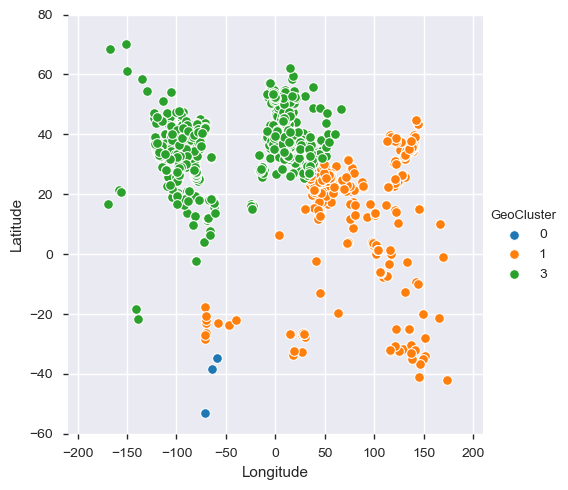

<Figure size 2800x1800 with 0 Axes>

In [287]:
##Need to review this, doesn't look right
sns.pairplot(x_vars=["Longitude"], y_vars=["Latitude"], data=test, hue="GeoCluster", size=5)
plt.xlim([-210, 210])
plt.ylim([-60, 80])
plt.figure(figsize=(28, 18))

<h3>Preparing Data for Regression</h3>
In order to perform a linear regression, we need to transform categorical data into one-hot (0/1) vectors. This code performs that task on both the training and test data sets. This is executed in abstraction, meaning we do not need to be aware of the different values that are included within a categorical feature. 

In [288]:
#Convert relavent features into on-hot-vectors 

print('Converting Customer type to one-hot')
train['Customer type'] = train['Customer type'].replace(np.nan,'Null Customer')
customer_types = train['Customer type'].unique()
for c in customer_types:
    train[c] = train.apply(lambda x:int(x['Customer type'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['Customer type'] == c),axis=1)

print('Converting Feedwater to one-hot')    
train['Feedwater'] = train['Feedwater'].replace(np.nan,'Null Feedwater')
feedwater = train['Feedwater'].unique()
for c in feedwater:
    train[c] = train.apply(lambda x:int(x['Feedwater'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['Feedwater'] == c),axis=1)

print('Converting Location Type to one-hot')    
train['Location type'] = train['Location type'].replace(np.nan,'Null Location Type')
loc_type = train['Location type'].unique()
for c in loc_type:
    train[c] = train.apply(lambda x:int(x['Location type'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['Location type'] == c),axis=1)

print('Converting Plant Type to one-hot') 
train['Plant type'] = train['Plant type'].replace(np.nan,'Null Plant Type')
plant_type = train['Plant type'].unique()
for c in plant_type:
    train[c] = train.apply(lambda x:int(x['Plant type'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['Plant type'] == c),axis=1)

print('Converting RO Feed Pump Drive to one-hot')    
train['RO Feed Pump Drive'] = train['RO Feed Pump Drive'].replace(np.nan,'Null Feed Pump')
feed_pump = train['RO Feed Pump Drive'].unique()
for c in feed_pump:
    train[c] = train.apply(lambda x:int(x['RO Feed Pump Drive'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['RO Feed Pump Drive'] == c),axis=1)

print('Converting RO Membrane Type to one-hot')    
train['RO Membrane Type'] = train['RO Membrane Type'].replace(np.nan,'Null Membrane Type')
membrane = train['RO Membrane Type'].unique()
for c in membrane:
    train[c] = train.apply(lambda x:int(x['RO Membrane Type'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['RO Membrane Type'] == c),axis=1)
    
print('Converting RO System to one-hot')    
train['RO System'] = train['RO System'].replace(np.nan,'Null RO System')
system = train['RO System'].unique()
for c in system:
    train[c] = train.apply(lambda x:int(x['RO System'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['RO System'] == c),axis=1)

print('Converting Size to one-hot')    
train['Size'] = train['Size'].replace(np.nan,'Null Size')
sizes = train['Size'].unique()
for c in membrane:
    train[c] = train.apply(lambda x:int(x['Size'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['Size'] == c),axis=1)
   
print('Converting Technology to one-hot')    
train['Technology'] = train['Technology'].replace(np.nan,'Null Technology')
tech = train['Technology'].unique()
for c in membrane:
    train[c] = train.apply(lambda x:int(x['Technology'] == c),axis=1)
    test[c] = test.apply(lambda x:int(x['Technology'] == c),axis=1)

Converting Customer type to one-hot


C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

Converting Feedwater to one-hot


C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Converting Location Type to one-hot


C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

Converting Plant Type to one-hot


C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

Converting RO Feed Pump Drive to one-hot


C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

Converting RO Membrane Type to one-hot


C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

Converting RO System to one-hot


C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

Converting Size to one-hot


C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

Converting Technology to one-hot


C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Rohan\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

Here we drop any numeric fields from our prior cleaning that are no longer necessary, and set the same fields to the test set. 

In [289]:
# pd.describe returns the numeric fields, .keys() returns those field names. Then drop the dirty or useless fields
train_numeric = train[train.describe().keys()].drop(columns=['Award date','EPC price','Plant supplier share','Online date','Water price (USD/m3)','Water Year','Water Cost','Water Inflation Multiple'])

In [290]:
#use the same fields for the test set
test_numeric = test[train_numeric.keys()]

<h3>Feature Selection</h3>
1. Built a correlation matrix and removed highly correlated features with a rho > 0.7
2. Split the data into prediction and prediction (_X and _Y sets)
3. Built OLS regression and reviewed p-values. Removed fields with a p-value > 0.5 or null p-value. Interestingly Water Cost provided a p-value of ~0.3, but we know it is important to the equation so we relaxed the critical value threshold to include it. 
4. Rebuilt the OLS regression using refined predictors
5. Reviewed the correlation matrix of new predictor set and removed another highly correlated feature (Null Location Type)

In [291]:
#create correlation matrix
corr_matrix = train_numeric.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [292]:
to_drop

['Unit size (m3/d)',
 'GeoCluster',
 'Offshore',
 'Null Plant Type',
 'Electric Motor',
 'Null RO System',
 'Single Pass']

In [293]:
train_numeric = train_numeric.drop(columns=to_drop)
train_numeric.dropna(inplace=True)
test_numeric = test_numeric.drop(columns=to_drop)
test_numeric.dropna(inplace=True)

train_X = train_numeric.drop(columns=['Inflation Adjusted EPC'])
train_Y = train_numeric['Inflation Adjusted EPC']
test_X = test_numeric.drop(columns=['Inflation Adjusted EPC'])
test_Y = test_numeric['Inflation Adjusted EPC']

In [294]:
train_numeric.head()

,Capacity (MGD),Inflation Adjusted EPC,Inflation Adjusted Wellhead Natural Gas Price,Latitude,Longitude,Units,Water Stress,Inflation Adjusted Water Cost,Power stations (TDS <10ppm),Industry (TDS <10ppm),...,Mobile,Stand-alone,Dual Purpose,Null Feed Pump,Null Membrane Type,Hollow Fibre Membrane,Spiral Wound Membrane,Tube Membrane,Flat membrane (FM),Two Pass
0,0.087354,0.680975,0.454403,53.766667,-2.716667,1.693646,2.868265,0.65724,1,0,...,0,1,0,1,0,0,0,0,0,0
2,0.262063,1.697497,0.410128,54.950000,-1.650000,4.234116,2.868265,0.65724,1,0,...,0,1,0,1,0,0,0,0,0,0
3,0.203826,1.341831,0.410128,51.466667,-0.150000,1.693646,2.868265,0.65724,1,0,...,0,1,0,1,0,0,0,0,0,0
5,0.029118,0.194000,0.410128,52.000000,-2.416667,0.846823,2.868265,0.65724,1,0,...,0,1,0,1,0,0,0,0,0,0
6,0.029118,0.179510,0.430358,53.400000,-3.033333,0.846823,2.868265,0.65724,1,0,...,0,1,0,1,0,0,0,0,0,0


In [295]:
import statsmodels.api as sm
X = sm.add_constant(train_X)
model = sm.OLS(train_Y,X).fit()
model.summary()

C:\Users\Rohan\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Rohan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Rohan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Rohan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Inflation Adjusted EPC   R-squared:                       0.555
Model:                                OLS   Adj. R-squared:                  0.553
Method:                     Least Squares   F-statistic:                     244.1
Date:                    Thu, 29 Nov 2018   Prob (F-statistic):               0.00
Time:                            22:07:25   Log-Likelihood:                -4698.8
No. Observations:                    4723   AIC:                             9448.
Df Residuals:                        4698   BIC:                             9609.
Df Model:                              24                                         
Covariance Type:                nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                   -1.1651      0.245     -4.753      0.000      -1.646      -0.685
Capacity (MGD)                                                           0.6343      0.011     57.009      0.000       0.612       0.656
Inflation Adjusted Wellhead Natural Gas Price                           -0.1006      0.010     -9.957      0.000      -0.120      -0.081
Latitude                                                                 0.0007      0.001      0.895      0.371      -0.001       0.002
Longitude                                                               -0.0006      0.000     -3.427      0.001      -0.001      -0.000
Units                                                                    0.0817      0.010      8.056      0.000       0.062       0.102
Water Stress                                                             0.0321      0.011      2.808      0.005       0.010       0.054
Inflation Adjusted Water Cost                                            0.0136      0.004      3.113      0.002       0.005       0.022
Power stations (TDS <10ppm)                                              0.0185      0.049      0.376      0.707      -0.078       0.115
Industry (TDS <10ppm)                                                   -0.0423      0.043     -0.989      0.323      -0.126       0.042
Municipalities as drinking water (TDS 10ppm - <1000ppm)                 -0.1114      0.045     -2.475      0.013      -0.200      -0.023
Tourist facilities as drinking water (TDS 10ppm - <1000ppm)             -0.3912      0.054     -7.266      0.000      -0.497      -0.286
Demonstration                                                           -0.2784      0.099     -2.805      0.005      -0.473      -0.084
Discharge                                                               -0.2944      0.103     -2.851      0.004      -0.497      -0.092
Irrigation (TDS <1000ppm)                                               -0.0660      0.066     -1.003      0.316      -0.195       0.063
Brackish water or inland water (TDS 3000ppm - <20000ppm)                -0.3200      0.047     -6.778      0.000      -0.413      -0.227
River water or low concentrated saline water (TDS 500ppm - <3000ppm)    -0.5492      0.054    -10.259      0.000      -0.654      -0.444
Seawater (TDS 20000ppm - 50000ppm)                                       0.2761      0.049      5.684      0.000       0.181       0.371
Brine or concentrated seawater (TDS >50000ppm)                           0.0952      0.120      0.791      0.429      -0.141       0.331
Wastewater               

In [296]:
train_X = train_X[((model.pvalues.notna()) & (model.pvalues < 0.5))[((model.pvalues.notna()) & (model.pvalues < 0.5))==True].keys().drop('const')]
test_X = test_X[((model.pvalues.notna()) & (model.pvalues < 0.5))[((model.pvalues.notna()) & (model.pvalues < 0.5))==True].keys().drop('const')]

In [297]:
X = sm.add_constant(train_X)
model = sm.OLS(train_Y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Inflation Adjusted EPC   R-squared:                       0.555
Model:                                OLS   Adj. R-squared:                  0.553
Method:                     Least Squares   F-statistic:                     244.1
Date:                    Thu, 29 Nov 2018   Prob (F-statistic):               0.00
Time:                            22:07:48   Log-Likelihood:                -4698.8
No. Observations:                    4723   AIC:                             9448.
Df Residuals:                        4698   BIC:                             9609.
Df Model:                              24                                         
Covariance Type:                nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                   -1.1493      0.277     -4.156      0.000      -1.691      -0.607
Capacity (MGD)                                                           0.6343      0.011     57.009      0.000       0.612       0.656
Inflation Adjusted Wellhead Natural Gas Price                           -0.1006      0.010     -9.957      0.000      -0.120      -0.081
Latitude                                                                 0.0007      0.001      0.895      0.371      -0.001       0.002
Longitude                                                               -0.0006      0.000     -3.427      0.001      -0.001      -0.000
Units                                                                    0.0817      0.010      8.056      0.000       0.062       0.102
Water Stress                                                             0.0321      0.011      2.808      0.005       0.010       0.054
Inflation Adjusted Water Cost                                            0.0136      0.004      3.113      0.002       0.005       0.022
Industry (TDS <10ppm)                                                   -0.0608      0.033     -1.868      0.062      -0.125       0.003
Municipalities as drinking water (TDS 10ppm - <1000ppm)                 -0.1299      0.036     -3.618      0.000      -0.200      -0.060
Tourist facilities as drinking water (TDS 10ppm - <1000ppm)             -0.4097      0.050     -8.144      0.000      -0.508      -0.311
Demonstration                                                           -0.2969      0.108     -2.752      0.006      -0.508      -0.085
Discharge                                                               -0.3129      0.113     -2.765      0.006      -0.535      -0.091
Irrigation (TDS <1000ppm)                                               -0.0845      0.068     -1.245      0.213      -0.217       0.049
Brackish water or inland water (TDS 3000ppm - <20000ppm)                -0.3173      0.051     -6.165      0.000      -0.418      -0.216
River water or low concentrated saline water (TDS 500ppm - <3000ppm)    -0.5466      0.057     -9.523      0.000      -0.659      -0.434
Seawater (TDS 20000ppm - 50000ppm)                                       0.2787      0.053      5.281      0.000       0.175       0.382
Brine or concentrated seawater (TDS >50000ppm)                           0.0979      0.122      0.799      0.424      -0.142       0.338
Wastewater                                                              -0.1449      0.060     -2.399      0.016      -0.263      -0.027
Pure water or tap water (

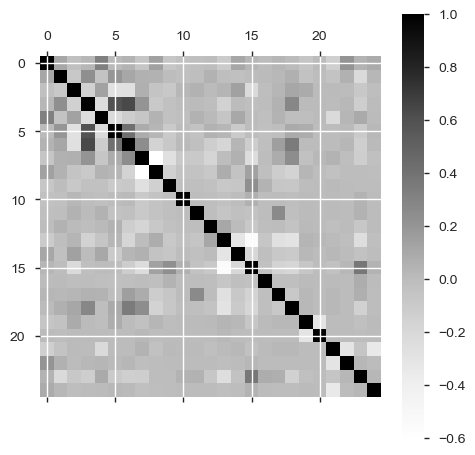

In [298]:
plt.matshow(train_X.corr())
plt.colorbar()

In [299]:
train_X = train_X.drop(columns='Null Location Type')
test_X = test_X.drop(columns='Null Location Type')
plt.matshow(train_X.corr())
plt.colorbar()

KeyError: "['Null Location Type'] not found in axis"

<h3>Model Fitting and Evaluation</h3>
Using sklearn's LinearRegression() we build an OLS model against the training data. Although this yields an R^2 of 0.56, the RMSE of percent differences in the test set is quite high (+200%). This is likely attributed to overfitting in the training set of high prices plants compared to the test set's lower priced plants. Looking at the output in a graph, the model seems reasonable. 

One important point to recall is that at this point we are still predicting the normalized Inflation Adjusted EPC (normalized by the Geo Cluster). 

R^2 = 0.5549210818512916
RMSE = 2.2942292433522455


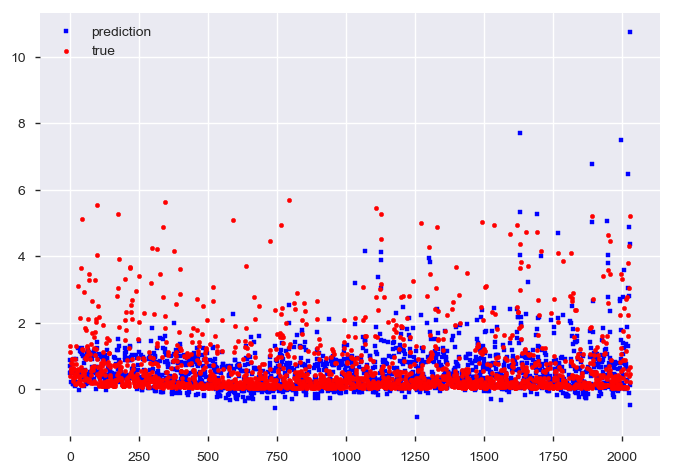

In [300]:
from math import sqrt
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(train_X,train_Y)
#Score returns the regression R^2
print('R^2 = ' + str(model.score(train_X,train_Y)))

prediction_Y = model.predict(test_X)
print('RMSE = '+str(sqrt(((prediction_Y-test_Y)/test_Y).apply(lambda x:x**2).mean())))

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(range(len(prediction_Y)), prediction_Y, s=10, c='b', marker="s", label='prediction')
ax1.scatter(range(len(test_Y)),test_Y, s=10, c='r', marker="o", label='true')
plt.legend(loc='upper left');
plt.show()

<h3>User Interface</h3>
1. User inputs each of the relevant features inline
2. Predict the new plant's Geo Cluster using Latitude and Longitude
3. Use the Geo Cluster to normalize the continuous input variables
4. Iterate through the training set features compared to user inputs to produce a one-hot feature set

In [ ]:
# cp = input("Enter Capacity (MGD) (as float) ")
lt = input("Enter Latitude (as float) ")
lg = input("Enter Longitude (as float) ")
ut = input("Enter Units (as float) ")
iaw = input("Enter Inflation Adjusted Water Cost (as float) ")

print('Supported Customer Types')
customer_t = np.append(customer_types,['Other'])
i = 0
for c in customer_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
ct = input("Enter Customer Type (as integer) ")

print('Supported Feedwaters')
feedwater_t = np.append(feedwater,['Other'])
i = 0
for c in feedwater_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
ft = input("Enter Feedwater (as integer) ")

print('Supported Location Types')
location_t = np.append(loc_type,['Other'])
i = 0
for c in location_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
loct = input("Enter Location Type (as integer) ")

print('Supported Plant Types')
plant_t = np.append(plant_type,['Other'])
i = 0
for c in plant_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
pt = input("Enter Plant Type (as integer) ")

print('Supported Membrane Types')
memb_t = np.append(membrane,['Other'])
i = 0
for c in memb_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
mt = input("Enter Membrane Type (as integer) ")

print('Supported System Types')
sys_t = np.append(system,['Other'])
i = 0
for c in sys_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
syt = input("Enter System Type (as integer) ")

print('Supported Sizes')
size_t = np.append(sizes,['Other'])
i = 0
for c in size_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
st = input("Enter Size (as integer) ")

print('Supported Technology Types')
tech_t = np.append(tech,['Other'])
i = 0
for c in tech_t:
    print('-- '+str(i)+') '+str(c))
    i += 1
tt = input("Enter Technology Type (as integer) ")


In [ ]:
mdf.iloc[:5][['Capacity (MGD)','Latitude','Longitude','Units','Inflation Adjusted Water Cost','Technology']]

In [158]:
geo = kmeans.predict(input_frame[['Latitude','Longitude']])[0]

input_frame = pd.DataFrame(columns=['Capacity (MGD)','Latitude','Longitude','Units','Inflation Adjusted Water Cost','GeoCluster'])
input_frame.loc[0] = [float(cp),float(lt),float(lg),float(ut),float(iaw),geo]

In [159]:
#one_hot = list()
for t in train_X.keys()[6:]:
    print(t)
    if(t == customer_t[int(ct)]):
        one_hot=1
    elif(t == feedwater_t[int(ft)]):
        one_hot=1
    elif(t == location_t[int(loct)]):
        one_hot=1
    elif(t == plant_t[int(pt)]):
        one_hot=1
    elif(t == memb_t[int(mt)]):
        one_hot=1
    elif(t == sys_t[int(syt)]):
        one_hot=1
    elif(t == size_t[int(st)]):
        one_hot=1
    elif(t == tech[int(tt)]):
        one_hot=1
    else:
        one_hot=0
    input_frame[t] = one_hot

input_frame

Industry (TDS <10ppm)
Municipalities as drinking water (TDS 10ppm - <1000ppm)
Tourist facilities as drinking water (TDS 10ppm - <1000ppm)
Discharge
Irrigation (TDS <1000ppm)
Demonstration
River water or low concentrated saline water (TDS 500ppm - <3000ppm)
Brackish water or inland water (TDS 3000ppm - <20000ppm)
Seawater (TDS 20000ppm - 50000ppm)
Wastewater
Pure water or tap water (TDS <500ppm)
Brine or concentrated seawater (TDS >50000ppm)
Land based
Mobile
Stand-alone
Electric Motor
Two Pass


,Capacity (MGD),Latitude,Longitude,Units,Inflation Adjusted Water Cost,GeoCluster,Industry (TDS <10ppm),Municipalities as drinking water (TDS 10ppm - <1000ppm),Tourist facilities as drinking water (TDS 10ppm - <1000ppm),Discharge,...,Brackish water or inland water (TDS 3000ppm - <20000ppm),Seawater (TDS 20000ppm - 50000ppm),Wastewater,Pure water or tap water (TDS <500ppm),Brine or concentrated seawater (TDS >50000ppm),Land based,Mobile,Stand-alone,Electric Motor,Two Pass
0,100.0,-40.5,-78.0,25.0,3.46,1.0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [160]:
for f in ['Capacity (MGD)','Units','Inflation Adjusted Water Cost']:
    input_norm = pd.DataFrame(input_frame.apply(lambda x:float(clusterNormalize(x[f],f,x['GeoCluster'])),axis=1)).set_index(input_frame.index)
    input_frame[f] = input_norm

Important! After we make our prediction, we need to use unnormalizeEPC to scale back up to USD using the Geo Clusters standard deviation of Inflation Adjusted EPC. 

In [161]:
def unnormalizeEPC(pred,field,cluster):
    return pred*(cluster_summary.get(cluster).get(field).get('sdev'))

In [162]:
expected_cost = unnormalizeEPC(model.predict(input_frame)[0],'Inflation Adjusted EPC',input_frame['GeoCluster'][0])
print('Your salination plant is expected to have an EPC of $'+"{:,}".format(round(expected_cost,2)))

Your salination plant is expected to have an EPC of $287,246,156.8
